In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# from matplotlib import rc
# # rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)


# Driven Dissipative Dynamics


In [2]:
# Expectation values for a(n open) system coupled to a classical driving field. 
# Rabi oscillations are easily found. 

def Rabi(w_in,gamma_in):

    #
    # problem parameters:
    #
    delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
    eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
    A =  0.01 * 2 * np.pi     # drive amplitude (reducing -> RWA more accurate)
    w = w_in * 2 * np.pi     # drive frequency
    gamma1 = gamma_in        # relaxation rate
    n_th = 0.0               # average number of excitations ("temperature")
    psi0 = basis(2, 1)       # initial state

    #
    # Hamiltonian
    #
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta / 2.0 * sx - eps0 / 2.0 * sz
    H1 = - A * sx

    # define the time-dependence of the hamiltonian using the list-string format
    args = {'w': w}
    Ht = [H0, [H1, 'sin(w*t)']]

    #
    # collapse operators
    #
    c_op_list = []

    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)       # relaxation

    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm.dag())  # excitation

    #
    # evolve and system subject to the time-dependent hamiltonian
    #
    tlist = np.linspace(0, 5.0 * 2 * np.pi / A, 500)
    output1 = mesolve(Ht, psi0, tlist, c_op_list, [sm.dag() * sm], args)

    # Alternative: write the hamiltonian in a rotating frame, and neglect the
    # the high frequency component (rotating wave approximation), so that the
    # resulting Hamiltonian is time-independent.
    H_rwa = - delta / 2.0 * sx - A * sx / 2
    output2 = mesolve(H_rwa, psi0, tlist, c_op_list, [sm.dag() * sm])

    #
    # Plot the solution
    #
    plt.plot(tlist, np.real(output1.expect[0]), 'b', tlist, np.real(output2.expect[0]), 'r')
    plt.xlabel('Time')
    plt.ylabel('Occupation probability')
    plt.title('Excitation probabilty of qubit')
    plt.legend(("Time-dependent Hamiltonian", "Corresponding RWA"))
    plt.show()

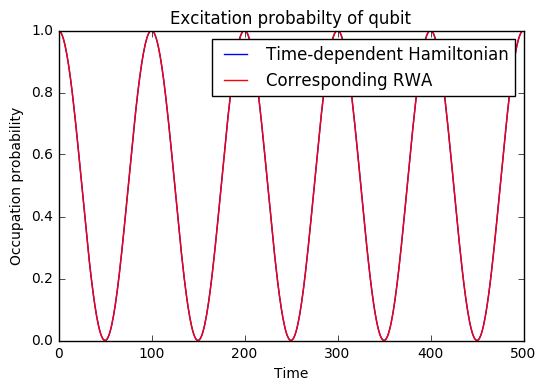

In [3]:
Rabi(1.0,.00)

# No EM field

Below we have a simple simulation of Rabi oscillations in a two level system mediated by a resonant driving field. 

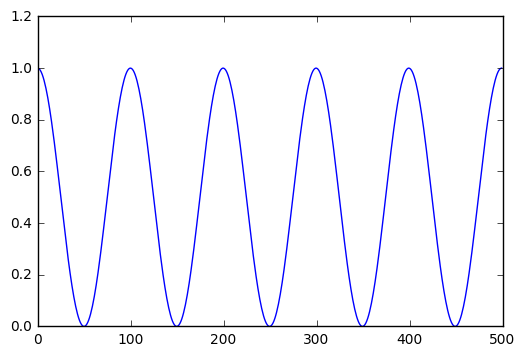

In [5]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  0.01 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w = 1.0  * 2 * np.pi     # drive frequency
gamma1 = 0.00            # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")

psi0 = basis(2, 1)       # initial state

#
# Hamiltonian
#
sx = sigmax()
sz = sigmaz()
sm = destroy(2)

H0 = - delta / 2.0 * sx - eps0 / 2.0 * sz
H1 = - A * sx

# define the time-dependence of the hamiltonian using the list-string format
args = {'w': w}
Ht = [H0, [H1, 'sin(w*t)']]

#
# collapse operators
#

c_op_list = []

rate = gamma1 * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm)        # relaxation

rate = gamma1 * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm.dag())  # excitation

#
# evolve and system subject to the time-dependent hamiltonian
#
tlist = np.linspace(0, 5.0 * 2 * np.pi / A, 500)
output1 = mesolve(Ht, psi0, tlist, c_op_list, [sm.dag() * sm , qeye(2)-sm.dag() * sm ], args)


rho_fin = output1.expect[0][499]

g2_tau = [output1.expect[0][iii]/rho_fin for iii in range(500)]

plt.plot(g2_tau)
plt.show()

plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.legend(("Excited state", "Ground state"))
plt.show()

#     plt.plot(tlist, np.real(output1.expect[0]), 'b', tlist, np.real(output2.expect[0]), 'r')
#     plt.xlabel('Time')
#     plt.ylabel('Occupation probability')
#     plt.title('Excitation probabilty of qubit')
#     plt.legend(("Time-dependent Hamiltonian", "Corresponding RWA"))
#     plt.show()

# Add Quantum Electromagnetic Field

We now extend the above simulation to the case in which the two level system is (strongly) coupled to a (leaky) cavity mode. We perform this calculation in order to directly calculate the $g^{(2)}(\tau)$ second-order coherence function. 

In [76]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  10.0 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 16                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.5               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes

#
# Hamiltonian
#

sx = tensor(sigmax(),qeye(M))
sz = tensor(sigmaz(),qeye(M))
sm = tensor(destroy(2),qeye(M))
a  = tensor(qeye(2),destroy(M))

H0   = - eps0 / 2.0 * sz + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm + sm.dag())

# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * sx
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 100 * 2 * np.pi / A, 1000000)


#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(M,1))

output0 = mesolve(Ht, psi0, tlist, c_op_list, [sm.dag() * sm, a.dag() * a], args)
n_ave_0 = expect(a.dag()*a,psi0) 

#
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# 

omega = expect(tensor(qeye(2),qeye(M)),a * psi0)
psi1 = 1/np.sqrt(omega) * a * psi0

output1 = mesolve(Ht, psi1, tlist, c_op_list, [sm.dag() * sm, a.dag() * a], args)

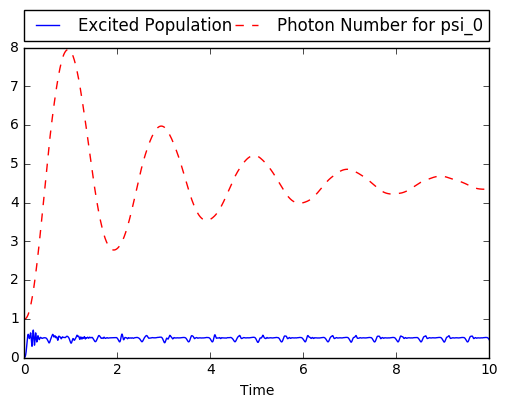

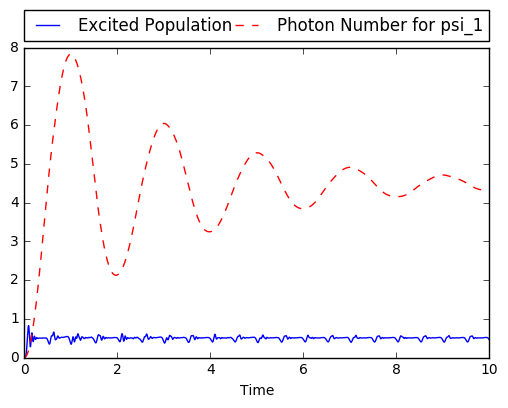

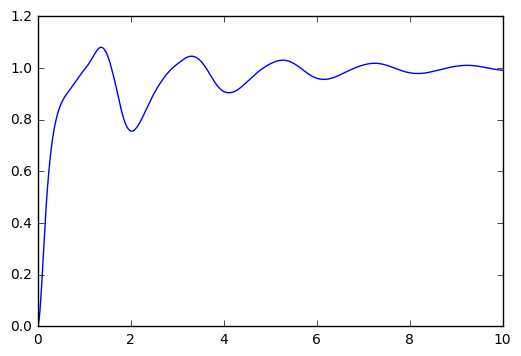

In [78]:
plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output0.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_0"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()


plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number for psi_1"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[1][iii]/(output0.expect[1][iii]) for iii in range(len(tlist))]
plt.plot(tlist, g_2)
plt.show(g_2)

# Multi-Spin System

### Two spins coupled to cavity

We now (again) extend the above calculation to the case in which many two level system are (strongly) coupled to a (leaky) cavity mode.

In [80]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  10.0 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 16                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.5               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes

#
# Hamiltonian
#

sx1 = tensor(sigmax(),qeye(2),qeye(M))
sz1 = tensor(sigmaz(),qeye(2),qeye(M))
sm1 = tensor(destroy(2),qeye(2),qeye(M))

sx2 = tensor(qeye(2),sigmax(),qeye(M))
sz2 = tensor(qeye(2),sigmaz(),qeye(M))
sm2 = tensor(qeye(2),destroy(2),qeye(M))
a  = tensor(qeye(2),qeye(2),destroy(M))


H0   = - eps0 / 2.0 * (sz1 + sz2) + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm1 + sm1.dag() + sm2 + sm2.dag())


# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * (sx1 + sx2)
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

#
# |y(t=0)>
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# and normalize |y'(t=0)> = 1/normalization |y'(t=0)>
psi0 = tensor(basis(2,1),basis(2,1),basis(M,3))
n_ave_0 = expect(a.dag()*a,psi0) 
omega = expect(tensor(qeye(2),qeye(2),qeye(M)),a * psi0)
psi1 = a * psi0

# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 100 * 2 * np.pi / A, 1000000)

#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(2,0),basis(M,1))

output0 = mesolve(Ht, psi0, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)
n_ave_0 = expect(a.dag()*a,psi0) 

#
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# 

omega = expect(tensor(qeye(2),qeye(2),qeye(M)),a * psi0)
psi1 = 1/np.sqrt(omega) * a * psi0

output1 = mesolve(Ht, psi1, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)


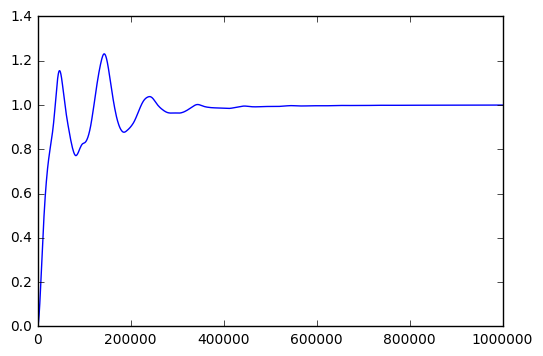

In [82]:
# plt.plot(tlist, output0.expect[0], 'b-')
# plt.plot(tlist, output0.expect[1], 'r--')
# plt.xlabel('Time')
# # plt.ylabel('Occupation probability')
# plt.legend(("Excited Population", "Photon Number"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# plt.show()


# plt.plot(tlist, output1.expect[0], 'b-')
# plt.plot(tlist, output1.expect[1], 'r--')
# plt.xlabel('Time')
# # plt.ylabel('Occupation probability')
# plt.legend(("Excited Population", "Photon Number"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[1][iii]/(n_ave_0 * output0.expect[1][iii]) for iii in range(len(tlist))]
plt.plot(g_2)
plt.show(g_2)

### Three spins coupled to cavity

In [3]:
#
# problem parameters:
#
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  10.0 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 16                    # Number of cavity modes not truncated
w_C = 1.0 * 2 * np.pi     # cavity mode level spacing
g12 = 10.0                # cavity / spin coupling strength
kappa = 0.5               # cavity relaxation rate
n_C_th = 0                # number of thermal cavity modes


#
# Hamiltonian
#

sx1 = tensor(sigmax(),qeye(2),qeye(2),qeye(M))
sz1 = tensor(sigmaz(),qeye(2),qeye(2),qeye(M))
sm1 = tensor(destroy(2),qeye(2),qeye(2),qeye(M))

sx2 = tensor(qeye(2),sigmax(),qeye(2),qeye(M))
sz2 = tensor(qeye(2),sigmaz(),qeye(2),qeye(M))
sm2 = tensor(qeye(2),destroy(2),qeye(2),qeye(M))

sx3 = tensor(qeye(2),qeye(2),sigmax(),qeye(M))
sz3 = tensor(qeye(2),qeye(2),sigmaz(),qeye(M))
sm3 = tensor(qeye(2),qeye(2),destroy(2),qeye(M))
a  = tensor(qeye(2),qeye(2),qeye(2),destroy(M))


H0   = - eps0 / 2.0 * (sz1 + sz2 + sz3) + w_C / 2 * a.dag()*a
Hint = g12 / 2 * (a + a.dag()) * (sm1 + sm1.dag() + sm2 + sm2.dag() + sm3 + sm3.dag())


# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * (sx1 + sx2 + sx3)
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 100 * 2 * np.pi / A, 1000000)


#
# |y(t=0)>
# 
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(M,1))

output0 = mesolve(Ht, psi0, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)
n_ave_0 = expect(a.dag()*a,psi0) 

#
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> 
# 

omega = expect(tensor(qeye(2),qeye(2),qeye(2),qeye(M)),a * psi0)
psi1 = 1/np.sqrt(omega) * a * psi0

output1 = mesolve(Ht, psi1, tlist, c_op_list, [sm1.dag() * sm1, a.dag() * a], args)


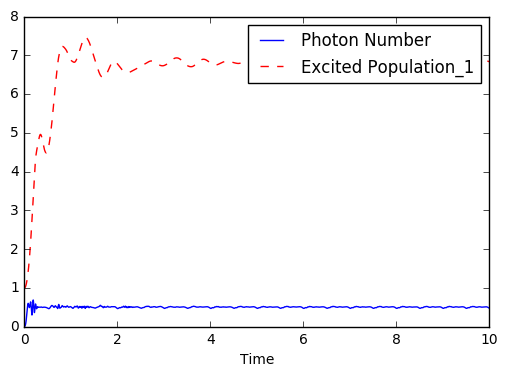

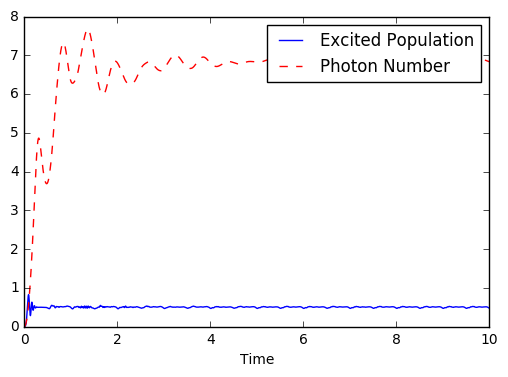

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


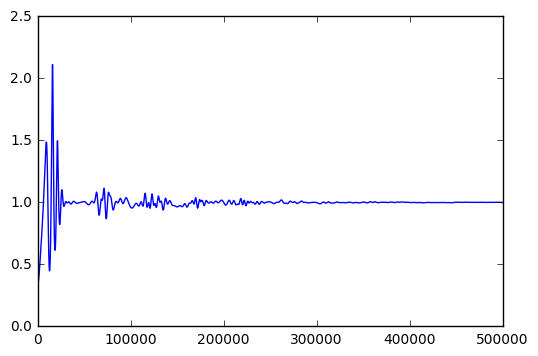

In [22]:
plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output0.expect[1], 'r--')
# plt.plot(tlist, output0.expect[2], 'g-')
# plt.plot(tlist, output0.expect[3], 'k--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Photon Number", "Excited Population_1"),)
plt.show()


plt.plot(tlist, output1.expect[0], 'b-')
plt.plot(tlist, output1.expect[1], 'r--')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(("Excited Population", "Photon Number"),)
plt.show()

# calculate g_2 by method detailed above
g_2 = [output1.expect[0][iii]/(n_ave_0 * output0.expect[0][iii]) for iii in range(len(tlist))]
plt.plot(g_2[:len(g_2)//2])
plt.show()

### Generalized  N-spin system

Finally, we genearlize the above simulation to include an arbitrary number of spins. The next step, to connect with 
experiment, will be to further generalize the Hamiltonian such that the driving amplitude is spatially modulated according to the positions of the spins relative to the electron beam. 

In [82]:
#
# problem parameters:
#
N = 5                    # number of spins
delta = 0.0 * 2 * np.pi  # qubit sigma_x coefficient
eps0 = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A =  1.50 * 2 * np.pi    # drive amplitude (reducing -> RWA more accurate)
w =  1.0 * 2 * np.pi     # drive frequency
gamma = 0.00             # relaxation rate
n_th = 0.0               # average number of excitations ("temperature")


M = 20                    # Number of cavity modes not truncated
w_C = 0.5 * 2 * np.pi     # cavity mode level spacing
g12 = 0.70                # cavity / spin coupling strength
kappa = 0.02              # cavity relaxation rate
n_C_th = 5                # number of thermal cavity modes


#
# Operators
#


pre_ID = [qeye(2)] * N
pre_ID.append(qeye(M))
ID = tensor(pre_ID)

def sx(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(pos):
    oplist = [qeye(2)] * N
    oplist[pos] = destroy(2)
    oplist.append(qeye(M))
    return tensor(oplist)

pre_a = [qeye(2)]*N 
pre_a.append(destroy(M))
a = tensor(pre_a)
n_a = a.dag() * a

H0 = - eps0 / 2.0 *  sum([sz(pos) for pos in range(N)]) + w_C / 2 * n_a
Hint = g12 / 2 * (a + a.dag()) * sum([sm(pos) + sm(pos).dag() for pos in range(N)])
# (sm1 + sm1.dag() + sm2 + sm2.dag() + sm3 + sm3.dag())
# define the time-dependence of the hamiltonian using the list-string format
H1 = - A * sum([sx(pos) for pos in range(N)])
args = {'w': w}
Ht = [H0 + Hint, [H1, 'sin(w*t)']]

#
# |y(t=0)>
# then destroy a single photon at time t=0: |y'(t=0)> = a * |y(t=0)> # and normalize |y'(t=0)> = 1/normalization |y'(t=0)>

pre_psi = [basis(2,0)] * N
pre_psi.append(basis(M,2))
psi0 = tensor(pre_psi)
n_ave_0 = expect(n_a,psi0) 
omega = expect(ID, a * psi0)
psi1 =  a * psi0


# Collapse operators
c_op_list = []

# leaky cavity 
c_op_list.append(np.sqrt(kappa * (n_C_th + 1)) * a)
c_op_list.append(np.sqrt(kappa * n_C_th) * a.dag())
# leaky spins --- dissipating into some other unknown field
# c_op_list.append(np.sqrt(gamma * (1 + n_th)) * sm)   # relaxation
# c_op_list.append(np.sqrt(gamma * n_th) * sm.dag())  # excitation

# discretized time domain
tlist = np.linspace(0, 40 * 2 * np.pi / A, 2000)

# expectation operators == e_ops
n_1_up = sm(1).dag() * sm(1)


output0 = mesolve(Ht, psi0, tlist, c_op_list, [n_a, n_1_up], args)
output1 = mesolve(Ht, psi1, tlist, c_op_list, [n_a], args)


KeyboardInterrupt: 

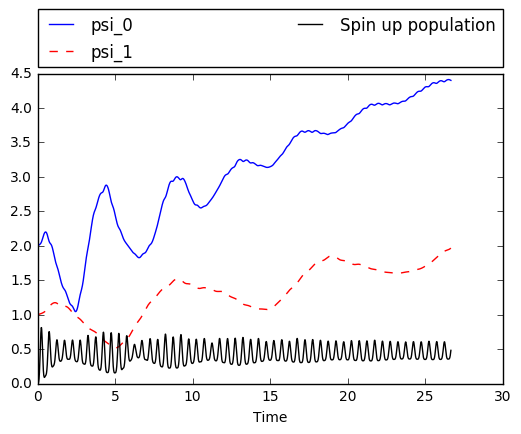

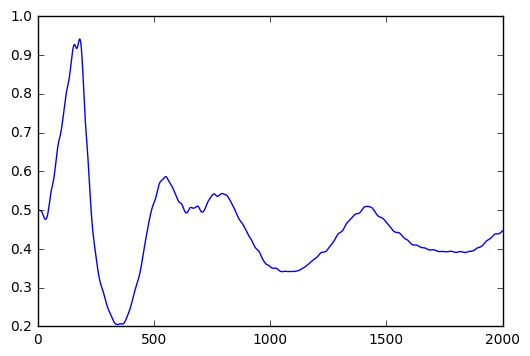

In [83]:
plt.plot(tlist, output0.expect[0], 'b-')
plt.plot(tlist, output1.expect[0]/omega, 'r--')
plt.plot(tlist, output0.expect[1], 'k-')
plt.xlabel('Time')
# plt.ylabel('Occupation probability')
plt.legend(('psi_0', "psi_1","Spin up population"),bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()


# calculate g_2 by method detailed above
g_2 = [output1.expect[0][iii]/(n_ave_0 * output0.expect[0][iii]) for iii in range(len(tlist))]
plt.plot(g_2)
plt.show(g_2)